### Code to detect circular gasometers from Sanborn Fire Insurance maps

#### This code implements the feature extraction portion from the following paper:
[Feature extraction and machine learning techniques for identifying historic urban environmental hazards: New methods to locate lost fossil fuel infrastructure in US cities](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0255507)

In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline  
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

from skimage.exposure import equalize_adapthist
from skimage.filters import threshold_otsu, unsharp_mask

In [3]:
def readInputImages(input_src: str) -> list:
    
    '''
    Function to return input images given input source directory
    
    '''
    
    input_img = []
    
    for filename in os.listdir(input_src):      
        
        input_img.append(os.path.join(input_src , filename))
        
    
    
    return input_img

    

In [4]:
input_src = os.getcwd() + '\\input'

input_img = readInputImages(input_src)


print('# of Input Images: {}'.format(len(input_img)))


# Gasometer: 03692_1923-0003.jpg

# of Input Images: 217


In [5]:
def detectHoughFilterCircles(input_img: str , k: int , save_path: str) -> list:
    
    '''
    Function to detect circle base don Hough Filters
    
    '''
    
    #print(input_img)
    
    src_img = cv2.imread(input_img)
    
    img_file_nm = 'roi' + str(k) + '.' + input_img.split('.')[-1]
    
    roi_file_nm = os.path.join(save_path , img_file_nm)

    
    # Create a copy of src image for reference
    output_img = src_img.copy()
    
    gray_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)
    
    # Create a mask for cropping
    mask_img = src_img.copy()
    
    # Range of vals for param2 optimization
    param2_range = list(range(65 , 125 , 5))

    roi = []
    
    # Threshold to detect circle
    max_circle_thresh = 1
    
    # Boolean flag
    skip = False
    
    
    
    # Apply Hough Filter
    for i in range(len(param2_range)):
        
        if skip:
            cv2.imwrite(roi_file_nm, cv2.resize(roi[0] , (64 , 64)))
            break

        # gas_circles = cv2.HoughCircles(img_gray, cv2.HOUGH_GRADIENT, 1, 20 , param1 = 20 , param2 = 70 , minRadius = 15 , maxRadius = 50)
        gas_circles = cv2.HoughCircles(gray_img, cv2.HOUGH_GRADIENT, minDist = 70 , dp = 1.1 , param1 = 20 , 
                                       param2 = param2_range[i] , minRadius = 15 , maxRadius = 50)

    
        # If a circle is detected
        if gas_circles is not None and len(gas_circles[0, :]) == max_circle_thresh and skip == False:
                    
            print('Circles detected: ' , len(gas_circles[0, :]) , ' for param2 value: ' , param2_range[i])
        
            # Convert the co-ordinates to integers
            gas_circles = np.round(gas_circles[0, :]).astype('int')
        
        
            for x , y , r in gas_circles:
            
              
            
                cv2.circle(output_img , (x , y) , r , (0 , 255 , 0) , 5)
                cv2.rectangle(output_img, (x - r * 2 , y - r * 2), (x + 100, y + 100), (0, 128, 255), 3)
#                 plt.figure(figsize = (14 , 12))
#                 plt.imshow(output_img , cmap = 'gray')
#                 plt.show()                                             
                
                img_h = output_img.shape[0]
                img_w = output_img.shape[1]
                
                # Create empty canvas
                empty_canvas = np.zeros((img_h , img_w))
            
                # Draw the required region to be sxtracted
                # cv2.circle(empty_canvas , (x , y) , r , (0 , 255 , 0) , 5)
                cv2.rectangle(empty_canvas , (x - r * 2 , y - r * 2), (x + 100, y + 100), (255, 255, 255), -1)
                
                # Create mask image from input image
                # mask_img = output_img.copy()
                mask_img[empty_canvas == 0] = (0 , 0 , 0)
                
                
                crop_start_x = abs(x - r)
                
          
                crop_start_y = abs(y - r)
                    
                h = 2 * r + 10
                w = 2 * r + 10
                
                # 641 24 96 96 43
                #print(crop_start_x , crop_start_y , h , w , r)
                
                cropped_img = mask_img[abs(crop_start_y - r) : crop_start_y + h + r, abs(crop_start_x - r): crop_start_x + w + r]
                print(cropped_img.shape)
                roi.append(cropped_img)
                
                
#                 plt.figure(figsize = (10 , 8))
#                 plt.imshow(cropped_img , cmap = 'gray')
#                 plt.title('Region of Interest')
#                 plt.show()                    
                skip = True
                
    
        # End of if block to check max circle threshold
        else:
        
            print('Circle not detected for param2 value: ', param2_range[i])
            continue

    return roi   

I have chosen an image *03692_1923-0003.jpg* having the required Gasometer marking to verify that the Hough Transform works as intended and detects circular regions. This is just for illustrating the working functionality of this code. A complete implemention will involve runng the list of images to generate training samples.

In [6]:
"""
input_img is a list of source images
The image at index 2 has the true Positive class and so is displayed here

"""

# Save folder for Region of Interest images
folder_nm = 'roi'
save_path = os.getcwd() + "\\" + folder_nm

if not os.path.isdir(save_path): 
        
    print('Save folder not found! creating.....')
    os.makedirs(save_path)
    

for k in range(len(input_img)):
    print('File name: ' , input_img[k])
    roi_img = detectHoughFilterCircles(input_img[k] , k , save_path)

File name:  D:\game making\machine_learning\Sanborn Image\input\03692_1923-0001.jpg
Circle not detected for param2 value:  65
Circles detected:  1  for param2 value:  70
(86, 86, 3)
File name:  D:\game making\machine_learning\Sanborn Image\input\03692_1923-0002.jpg
Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circle not detected for param2 value:  75
Circle not detected for param2 value:  80
Circle not detected for param2 value:  85
Circle not detected for param2 value:  90
Circle not detected for param2 value:  95
Circle not detected for param2 value:  100
Circle not detected for param2 value:  105
Circle not detected for param2 value:  110
Circle not detected for param2 value:  115
Circle not detected for param2 value:  120
File name:  D:\game making\machine_learning\Sanborn Image\input\03692_1923-0003.jpg
Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circle not detected for param2 value:  75
Circle not dete

Circles detected:  1  for param2 value:  65
(106, 106, 3)
File name:  D:\game making\machine_learning\Sanborn Image\input\08077_1903-0013.jpg
Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circle not detected for param2 value:  75
Circle not detected for param2 value:  80
Circle not detected for param2 value:  85
Circle not detected for param2 value:  90
Circle not detected for param2 value:  95
Circle not detected for param2 value:  100
Circle not detected for param2 value:  105
Circle not detected for param2 value:  110
Circle not detected for param2 value:  115
Circle not detected for param2 value:  120
File name:  D:\game making\machine_learning\Sanborn Image\input\08077_1911-0000.jpg
Circle not detected for param2 value:  65
Circles detected:  1  for param2 value:  70
(86, 86, 3)
File name:  D:\game making\machine_learning\Sanborn Image\input\08077_1911-0002.jpg
Circle not detected for param2 value:  65
Circles detected:  1  for param2 value:  

Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circle not detected for param2 value:  75
Circle not detected for param2 value:  80
Circles detected:  1  for param2 value:  85
(178, 178, 3)
File name:  D:\game making\machine_learning\Sanborn Image\input\08077_1920-0009.jpg
Circle not detected for param2 value:  65
Circles detected:  1  for param2 value:  70
(110, 110, 3)
File name:  D:\game making\machine_learning\Sanborn Image\input\08077_1920-0010.jpg
Circle not detected for param2 value:  65
Circles detected:  1  for param2 value:  70
(86, 86, 3)
File name:  D:\game making\machine_learning\Sanborn Image\input\08077_1920-0011.jpg
Circle not detected for param2 value:  65
Circles detected:  1  for param2 value:  70
(90, 90, 3)
File name:  D:\game making\machine_learning\Sanborn Image\input\08077_1920-0012.jpg
Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circles detected:  1  for param2 value:  75
(86, 86, 3)
Fi

Circle not detected for param2 value:  100
Circle not detected for param2 value:  105
Circle not detected for param2 value:  110
Circle not detected for param2 value:  115
Circle not detected for param2 value:  120
File name:  D:\game making\machine_learning\Sanborn Image\input\08077_1947-0020.jpg
Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circles detected:  1  for param2 value:  75
(90, 90, 3)
File name:  D:\game making\machine_learning\Sanborn Image\input\08079_1925-0001.jpg
Circles detected:  1  for param2 value:  65
(86, 86, 3)
File name:  D:\game making\machine_learning\Sanborn Image\input\08080_01_1956-0000.jpg
Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circle not detected for param2 value:  75
Circle not detected for param2 value:  80
Circle not detected for param2 value:  85
Circle not detected for param2 value:  90
Circle not detected for param2 value:  95
Circle not detected for param2 value:  1

Circle not detected for param2 value:  80
Circle not detected for param2 value:  85
Circle not detected for param2 value:  90
Circle not detected for param2 value:  95
Circle not detected for param2 value:  100
Circle not detected for param2 value:  105
Circle not detected for param2 value:  110
Circle not detected for param2 value:  115
Circle not detected for param2 value:  120
File name:  D:\game making\machine_learning\Sanborn Image\input\08080_01_1956-0057.jpg
Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circle not detected for param2 value:  75
Circle not detected for param2 value:  80
Circle not detected for param2 value:  85
Circle not detected for param2 value:  90
Circle not detected for param2 value:  95
Circle not detected for param2 value:  100
Circle not detected for param2 value:  105
Circle not detected for param2 value:  110
Circle not detected for param2 value:  115
Circle not detected for param2 value:  120
File name:  D:\game m

Circle not detected for param2 value:  90
Circle not detected for param2 value:  95
Circle not detected for param2 value:  100
Circle not detected for param2 value:  105
Circle not detected for param2 value:  110
Circle not detected for param2 value:  115
Circle not detected for param2 value:  120
File name:  D:\game making\machine_learning\Sanborn Image\input\08080_01_1956-0072.jpg
Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circle not detected for param2 value:  75
Circle not detected for param2 value:  80
Circle not detected for param2 value:  85
Circle not detected for param2 value:  90
Circle not detected for param2 value:  95
Circle not detected for param2 value:  100
Circle not detected for param2 value:  105
Circle not detected for param2 value:  110
Circle not detected for param2 value:  115
Circle not detected for param2 value:  120
File name:  D:\game making\machine_learning\Sanborn Image\input\08080_01_1956-0073.jpg
Circle not detecte

Circle not detected for param2 value:  120
File name:  D:\game making\machine_learning\Sanborn Image\input\08080_01_1956-0086.jpg
Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circle not detected for param2 value:  75
Circle not detected for param2 value:  80
Circle not detected for param2 value:  85
Circle not detected for param2 value:  90
Circle not detected for param2 value:  95
Circle not detected for param2 value:  100
Circle not detected for param2 value:  105
Circle not detected for param2 value:  110
Circle not detected for param2 value:  115
Circle not detected for param2 value:  120
File name:  D:\game making\machine_learning\Sanborn Image\input\08080_01_1956-0087.jpg
Circles detected:  1  for param2 value:  65
(138, 138, 3)
File name:  D:\game making\machine_learning\Sanborn Image\input\08080_01_1956-0088.jpg
Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circle not detected for param2 value:  75
Cir

Circle not detected for param2 value:  115
Circle not detected for param2 value:  120
File name:  D:\game making\machine_learning\Sanborn Image\input\08080_01_1956-0103.jpg
Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circle not detected for param2 value:  75
Circle not detected for param2 value:  80
Circle not detected for param2 value:  85
Circle not detected for param2 value:  90
Circle not detected for param2 value:  95
Circle not detected for param2 value:  100
Circle not detected for param2 value:  105
Circle not detected for param2 value:  110
Circle not detected for param2 value:  115
Circle not detected for param2 value:  120
File name:  D:\game making\machine_learning\Sanborn Image\input\08080_01_1956-0104.jpg
Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circle not detected for param2 value:  75
Circle not detected for param2 value:  80
Circle not detected for param2 value:  85
Circle not detected f

Circle not detected for param2 value:  75
Circle not detected for param2 value:  80
Circle not detected for param2 value:  85
Circle not detected for param2 value:  90
Circle not detected for param2 value:  95
Circle not detected for param2 value:  100
Circle not detected for param2 value:  105
Circle not detected for param2 value:  110
Circle not detected for param2 value:  115
Circle not detected for param2 value:  120
File name:  D:\game making\machine_learning\Sanborn Image\input\08080_02_1956-0044.jpg
Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circle not detected for param2 value:  75
Circle not detected for param2 value:  80
Circle not detected for param2 value:  85
Circle not detected for param2 value:  90
Circle not detected for param2 value:  95
Circle not detected for param2 value:  100
Circle not detected for param2 value:  105
Circle not detected for param2 value:  110
Circle not detected for param2 value:  115
Circle not detected fo

Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circle not detected for param2 value:  75
Circle not detected for param2 value:  80
Circle not detected for param2 value:  85
Circle not detected for param2 value:  90
Circle not detected for param2 value:  95
Circle not detected for param2 value:  100
Circle not detected for param2 value:  105
Circle not detected for param2 value:  110
Circle not detected for param2 value:  115
Circle not detected for param2 value:  120
File name:  D:\game making\machine_learning\Sanborn Image\input\08080_02_1956-0058.jpg
Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circle not detected for param2 value:  75
Circle not detected for param2 value:  80
Circle not detected for param2 value:  85
Circle not detected for param2 value:  90
Circle not detected for param2 value:  95
Circle not detected for param2 value:  100
Circle not detected for param2 value:  105
Circle not detected for 

Circle not detected for param2 value:  115
Circle not detected for param2 value:  120
File name:  D:\game making\machine_learning\Sanborn Image\input\08080_02_1956-0072.jpg
Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circle not detected for param2 value:  75
Circle not detected for param2 value:  80
Circle not detected for param2 value:  85
Circle not detected for param2 value:  90
Circle not detected for param2 value:  95
Circle not detected for param2 value:  100
Circle not detected for param2 value:  105
Circle not detected for param2 value:  110
Circle not detected for param2 value:  115
Circle not detected for param2 value:  120
File name:  D:\game making\machine_learning\Sanborn Image\input\08080_02_1956-0073.jpg
Circle not detected for param2 value:  65
Circle not detected for param2 value:  70
Circle not detected for param2 value:  75
Circle not detected for param2 value:  80
Circle not detected for param2 value:  85
Circle not detected f

(82, 82, 3)


In [138]:
def extractText(img: np.ndarray) -> None:
    
    '''
    
    Function to detect and extract text from images
    
    '''
    img_detect = cv2.resize(img, (64 , 64), interpolation = cv2.INTER_AREA)
    
    
    
    img_detect = img.astype(np.uint8)
    # img_detect = unsharp_mask(img_detect)
    
    
    img_grey = cv2.cvtColor(img_detect, cv2.COLOR_BGR2GRAY)
    
    blur_img = cv2.GaussianBlur(img_grey, (5, 5), 0)
    
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpen = cv2.filter2D(blur_img, -1, sharpen_kernel)    
    
    #sharpen = sharpen.astype(np.uint8)
    #sharpen = cv2.cvtColor(sharpen, cv2.COLOR_BGR2GRAY)
    
    #print(img_grey.shape)
    
    # Apply pre-processing steps for the image
    # thresh = cv2.threshold(sharpen, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    thresh = cv2.adaptiveThreshold(blur_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 10)
    
    print(thresh.shape)
    
    # Morph open to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1) 
    
    
    # Detect Contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Fill contours
    contours = cv2.drawContours(opening, np.array(contours), -1, (255,255,255), -1)
    
    text = pytesseract.image_to_string(thresh, lang='eng',config='--psm 6')
    
    print([''.join([x.strip() for x in text.split('\n')])])
    # print(text)
    

    
 
    
    
    
    plt.imshow(thresh , cmap = 'gray')
    plt.show()
    
    

(110, 110)
['woh“+ 1is']


c:\users\ashwi\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


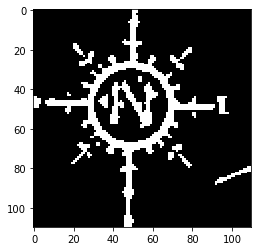

In [143]:
extractText(roi_img[0])